In [118]:
import os

USE_LOCAL_RUNTIME = True

if USE_LOCAL_RUNTIME:
    # '/home/tom/Workspace/hypeminer/misc/optimisation'
    os.chdir('C:/Users/Agando/Workspace/hypeminer/misc/optimisation') 
else:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/hypeminer/training-data/optimisation')

In [183]:
import json
import pandas as pd
from datetime import datetime

file = "BNBUSDT-20200101000000-5-365.json"

def get_value(v):
    try:
        return float(v['value'])
    except:
        return float(v['value'][0][1])

def load_file(file):
    df = pd.DataFrame()
    with open(file) as f:
        data = json.load(f)
    df['ds'] = [datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in data]
    df['open'] = [get_value(v) for v in data]
    return df

df = load_file(file)
df

,ds,open
0,2020-01-01 00:00:00,13.7159
1,2020-01-01 00:05:00,13.7010
2,2020-01-01 00:10:00,13.7125
3,2020-01-01 00:15:00,13.7051
4,2020-01-01 00:20:00,13.7024
...,...,...
105116,2020-12-30 23:40:00,38.0611
105117,2020-12-30 23:45:00,38.2087
105118,2020-12-30 23:50:00,38.1183
105119,2020-12-30 23:55:00,38.0900


In [184]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

df['ema12'] = ema(df['open'], 12)
df['ema26'] = ema(df['open'], 26)
df['macd'] = df['ema12'] - df['ema26']
df['signal'] = ema(df['macd'], 9)
df['macddiff'] = df['macd'] - df['signal']

df

,ds,open,ema12,ema26,macd,signal,macddiff
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374
...,...,...,...,...,...,...,...
105116,2020-12-30 23:40:00,38.0611,37.865194,37.818075,0.047120,0.028692,0.018427
105117,2020-12-30 23:45:00,38.2087,37.918041,37.847010,0.071032,0.037160,0.033871
105118,2020-12-30 23:50:00,38.1183,37.948850,37.867105,0.081745,0.046077,0.035668
105119,2020-12-30 23:55:00,38.0900,37.970566,37.883616,0.086950,0.054252,0.032698


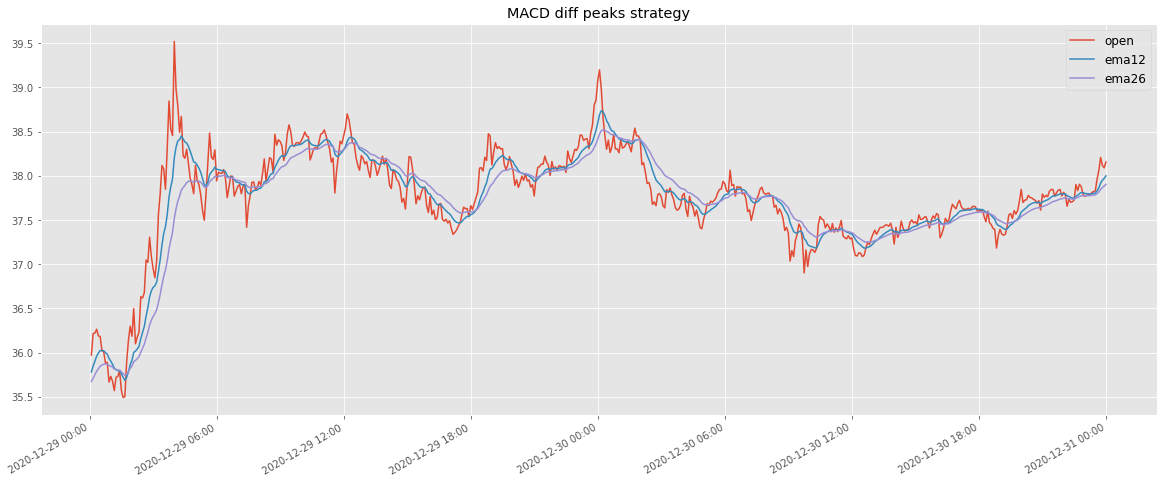

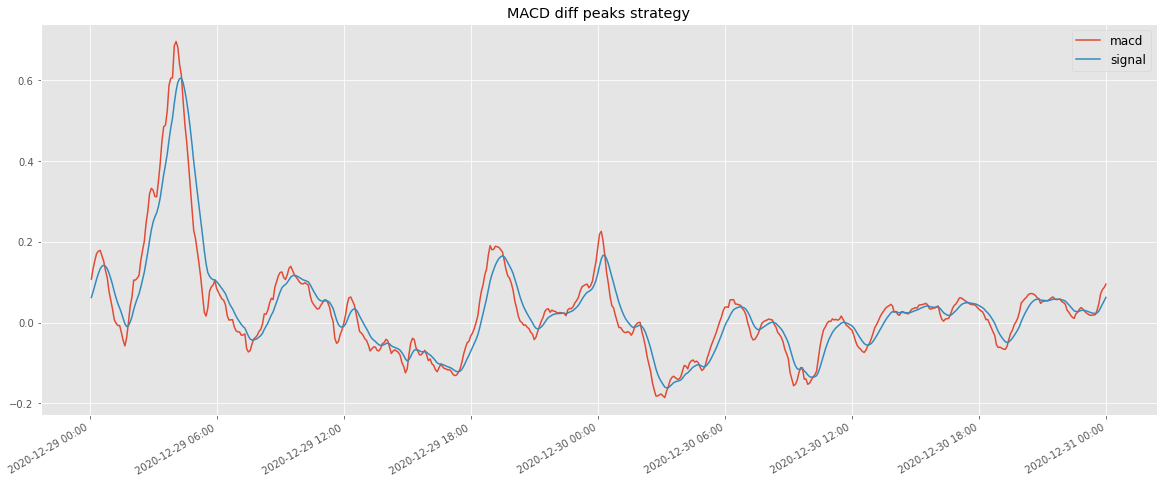

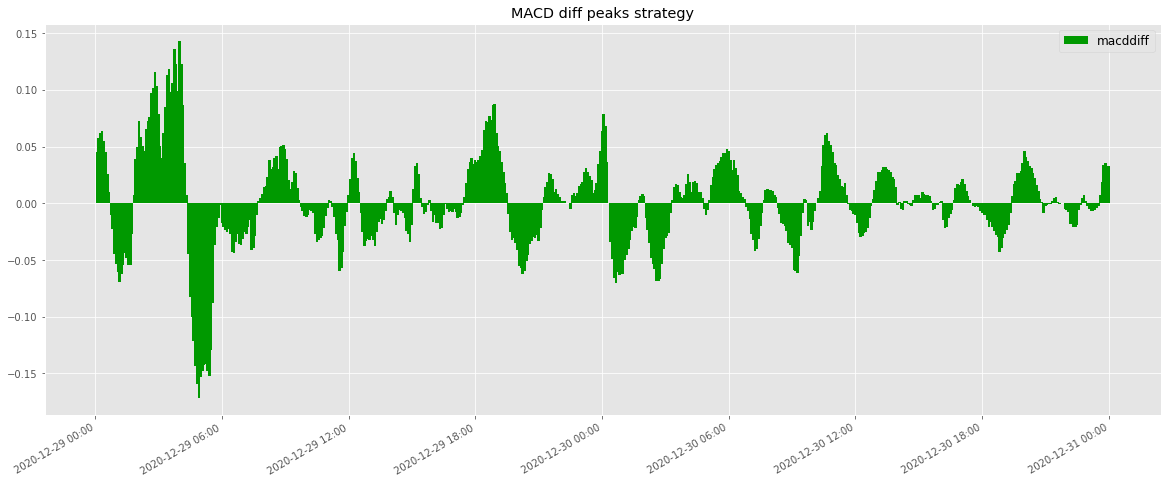

In [185]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

def plot(typ, dfs, cols, title, baseline=None):
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    for col in cols:
        if typ == 'line':
            plt.plot(dfs['ds'], dfs[col], label=col)
        elif typ == 'bars':
            plt.bar(dfs['ds'], dfs[col], color='#009900', label=col, width=.005)
    if baseline:
        plt.axhline(y=baseline, color='b', linestyle='-', label='buy and hold')
    plt.legend(loc="best", prop={'size': 12})
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.show()

samples = int(2 * 24 * 60 / 5)
dfs = df.iloc[-samples:]

plot('line', dfs, ['open', 'ema12', 'ema26'], "MACD diff peaks strategy")
plot('line', dfs, ['macd', 'signal'], "MACD diff peaks strategy")
plot('bars', dfs, ['macddiff'], "MACD diff peaks strategy")

In [188]:
df['prev_open'] = df['open'].shift(1)

df['is_negative'] = df['macddiff'] < 0
df['macddiff2'] = df['macddiff'].diff()
df['is_upward'] = df['macddiff'].diff() > 0

df['suggest'] = 'IDLE'
df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'

df.iloc[:30]

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,macddiff2,is_upward,action,suggest
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000,NaN,False,NaN,False,IDLE,IDLE
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951,13.7159,True,-0.000951,False,IDLE,IDLE
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761,13.7010,True,0.000190,True,BUY,BUY
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070,13.7125,True,-0.000309,False,IDLE,IDLE
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374,13.7051,True,-0.000304,False,IDLE,IDLE
5,2020-01-01 00:25:00,13.7023,13.709369,13.712270,-0.002901,-0.001411,-0.001489,13.7024,True,-0.000115,False,IDLE,IDLE
6,2020-01-01 00:30:00,13.7038,13.708512,13.711642,-0.003130,-0.001755,-0.001375,13.7023,True,0.000114,True,BUY,BUY
7,2020-01-01 00:35:00,13.7042,13.707849,13.711091,-0.003242,-0.002053,-0.001190,13.7038,True,0.000185,True,BUY,BUY
8,2020-01-01 00:40:00,13.7002,13.706672,13.710284,-0.003612,-0.002365,-0.001248,13.7042,True,-0.000058,False,IDLE,IDLE
9,2020-01-01 00:45:00,13.7043,13.706307,13.709841,-0.003534,-0.002598,-0.000936,13.7002,True,0.000312,True,BUY,BUY


,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,macddiff2,is_upward,action,suggest,limit,stop,assets
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000,NaN,False,NaN,False,----,IDLE,0.000000,0.000000,1.000000
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951,13.7159,True,-0.000951,False,----,IDLE,0.000000,0.000000,1.000000
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761,13.7010,True,0.000190,True,BUY,BUY,14.123875,12.478375,1.000000
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070,13.7125,True,-0.000309,False,----,IDLE,0.000000,0.000000,0.999460
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374,13.7051,True,-0.000304,False,----,IDLE,0.000000,0.000000,0.999263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,2020-12-30 23:40:00,38.0611,37.865194,37.818075,0.047120,0.028692,0.018427,37.9634,False,0.011570,True,----,IDLE,0.000000,0.000000,7.497207
105117,2020-12-30 23:45:00,38.2087,37.918041,37.847010,0.071032,0.037160,0.033871,38.0611,False,0.015444,True,----,IDLE,0.000000,0.000000,7.526281
105118,2020-12-30 23:50:00,38.1183,37.948850,37.867105,0.081745,0.046077,0.035668,38.2087,False,0.001796,True,----,IDLE,0.000000,0.000000,7.508474
105119,2020-12-30 23:55:00,38.0900,37.970566,37.883616,0.086950,0.054252,0.032698,38.1183,False,-0.002970,False,----,IDLE,0.000000,0.000000,7.502900


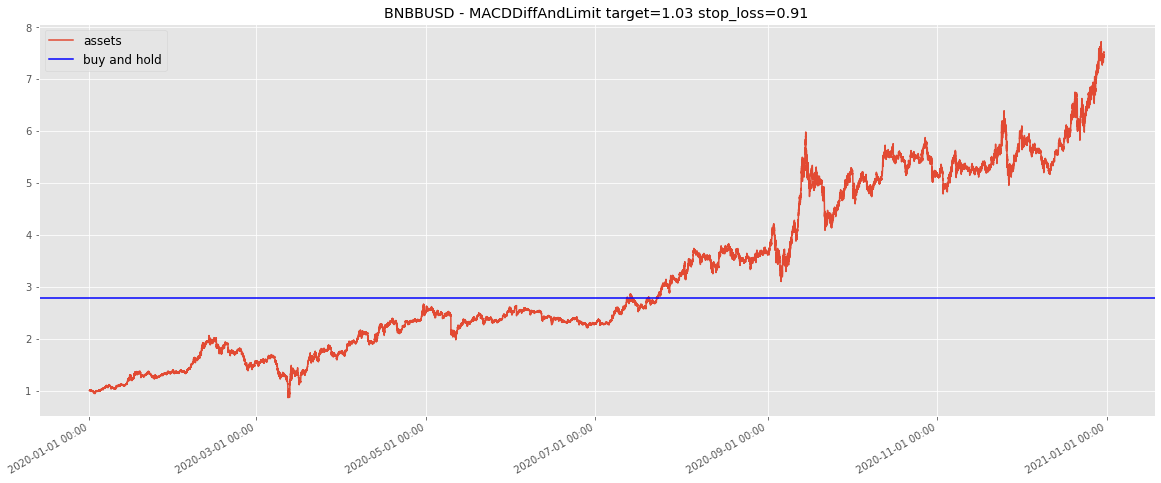

(7.515860966013719, 2.781866301154135)

In [195]:
from IPython.display import display

def compute_macd_diff_and_limit(target, stop_loss, verbose=False, plot_chart=False):

    df['limit'] = 0
    df.loc[df['suggest'] == 'BUY', 'limit'] = df['open'] * target

    df['stop'] = 0
    df.loc[df['suggest'] == 'BUY', 'stop'] = df['open'] * stop_loss

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1
    limit = None
    stop = None

    assets_values = []
    actions = []
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            limit = row['limit']
            stop = row['stop']
            actions.append('BUY')
        elif s == 'IN' and (row['open'] >= limit or row['open'] <= stop):
            s = 'OUT'
            limit = None
            stop = None
            actions.append('SELL')
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display(df)
    
    if plot_chart:
        plot('line', df, ['assets'], f"BNBBUSD - MACDDiffAndLimit target={target} stop_loss={stop_loss}", baseline=bnh)
    
    return assets, bnh

compute_macd_diff_and_limit(1.03, 0.91, verbose=True, plot_chart=True)

In [178]:
# import numpy as np

# for target in np.arange(1.01, 1.21, 0.01):
#     for stop_loss in np.arange(0.99, 0.79, -0.01):
#         stake, baseline = compute_macd_diff_and_limit(target, stop_loss)
#         print("\t".join(["{:.2f}".format(x) for x in [target, stop_loss, baseline, stake]]).expandtabs(8))

1.01    0.99    2.78    1.52
1.01    0.98    2.78    4.59
1.01    0.97    2.78    3.48
1.01    0.96    2.78    5.88
1.01    0.95    2.78    5.89
1.01    0.94    2.78    4.37
1.01    0.93    2.78    6.40
1.01    0.92    2.78    5.93
1.01    0.91    2.78    6.33
1.01    0.90    2.78    5.98
1.01    0.89    2.78    4.89
1.01    0.88    2.78    4.87
1.01    0.87    2.78    4.28
1.01    0.86    2.78    4.54
1.01    0.85    2.78    4.94
1.01    0.84    2.78    5.02
1.01    0.83    2.78    5.39
1.01    0.82    2.78    5.17
1.01    0.81    2.78    4.95
1.01    0.80    2.78    4.53
1.02    0.99    2.78    2.95
1.02    0.98    2.78    4.38
1.02    0.97    2.78    4.36
1.02    0.96    2.78    5.39
1.02    0.95    2.78    4.89
1.02    0.94    2.78    4.99
1.02    0.93    2.78    6.16
1.02    0.92    2.78    6.69
1.02    0.91    2.78    6.31
1.02    0.90    2.78    5.58
1.02    0.89    2.78    6.40
1.02    0.88    2.78    6.41
1.02    0.87    2.78    6.08
1.02    0.86    2.78    6.64
1.02    0.85  

1.15    0.96    2.78    4.23
1.15    0.95    2.78    4.76
1.15    0.94    2.78    4.88
1.15    0.93    2.78    4.16
1.15    0.92    2.78    4.05
1.15    0.91    2.78    4.19
1.15    0.90    2.78    3.79
1.15    0.89    2.78    4.08
1.15    0.88    2.78    3.77
1.15    0.87    2.78    3.37
1.15    0.86    2.78    3.68
1.15    0.85    2.78    4.45
1.15    0.84    2.78    4.00
1.15    0.83    2.78    3.45
1.15    0.82    2.78    3.45
1.15    0.81    2.78    3.29
1.15    0.80    2.78    3.22
1.16    0.99    2.78    3.95
1.16    0.98    2.78    3.75
1.16    0.97    2.78    4.19
1.16    0.96    2.78    3.30
1.16    0.95    2.78    4.70
1.16    0.94    2.78    3.82
1.16    0.93    2.78    4.44
1.16    0.92    2.78    4.25
1.16    0.91    2.78    3.83
1.16    0.90    2.78    3.58
1.16    0.89    2.78    3.74
1.16    0.88    2.78    3.34
1.16    0.87    2.78    3.54
1.16    0.86    2.78    3.79
1.16    0.85    2.78    3.71
1.16    0.84    2.78    4.16
1.16    0.83    2.78    4.26
1.16    0.82  